# Imports

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import yaml
from sklearn.model_selection import  cross_validate, train_test_split, KFold
from sklearn.metrics import  mean_squared_error, make_scorer
from sklearn.preprocessing import  StandardScaler, LabelEncoder
from sklearn.pipeline import  Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBRegressor as XGBR
from lightgbm import LGBMRegressor as LGBMR; 
import warnings
warnings.filterwarnings('ignore')

In [2]:
default_config_name = "../config/default.yaml"
with open(default_config_name, "r") as file: 
    default_config = yaml.safe_load(file)


In [3]:
default_config["mlflow"]["tracking_uri"]

'http://35.153.184.244:5000/'

In [4]:
mlflow.set_tracking_uri(default_config["mlflow"]["tracking_uri"])
mlflow.set_experiment(default_config["mlflow"]["experiment_name"])
print(f"tracking URI: {mlflow.get_tracking_uri()}")

tracking URI: http://35.153.184.244:5000/


# Reading the Data

We read the data and see that the training data has over four thousand rows and thirty three features.

Insight: 

1. Avoid algorithm that suffers from the curse of dimensionality(KNN, etc)
2. At some point we will need to use dimensionality reduction technique(PCA, t-SNE) or remove useless features.

In [5]:
train_data = pd.read_csv(default_config["data"]["raw_train_data_path"])
test_data = pd.read_csv(default_config["data"]["raw_test_data_path"])

train_data.shape

(4120, 33)

In [6]:
train_data.head()

,id,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,...,longitude,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,aerosol_optical_depth,dust,uv_index,uv_index_clear_sky
0,0,1.0,27.323000,14.823000,20.573002,25.777689,14.690771,19.505260,0,0,...,10.4179,32.275000,324.541667,1.706250,1.164583,90.208333,0.277083,9.916667,2.185417,2.189583
1,1,1.0,29.528000,17.528000,23.321753,32.480470,18.525795,24.953913,0,0,...,13.6833,12.837500,312.500000,0.118750,0.231250,57.791667,0.343333,2.958333,1.581250,1.979167
2,2,65.0,23.773000,15.323000,18.233418,24.630080,16.138641,19.608873,0,0,...,10.4179,20.445833,232.000000,1.827083,0.347917,54.416667,0.249167,16.625000,1.970833,2.566667
3,3,1.0,32.478000,19.227999,25.419668,35.235100,21.212915,27.534365,0,0,...,13.6833,30.583333,381.375000,0.358333,0.491667,53.958333,0.446667,3.333333,2.075000,2.218750
4,4,3.0,39.858498,28.508501,33.854332,42.387520,30.281784,35.202442,0,0,...,13.4000,38.733333,307.833333,1.429167,0.454167,61.500000,0.697500,74.916667,1.783333,2.170833


In [7]:
train_data.isnull().sum().sum(), test_data.isnull().sum().sum(), train_data.duplicated().sum().sum(), test_data.duplicated().sum().sum()

(0, 0, 0, 0)

No null values, no duplicates, the dataset appear to be relatively clean.

In [8]:
target = 'pm2_5'

# Target Distribution

The target distribution appear to be skewed to the right, this indicates the presence of outliers.The highest value for pm2_5 is 172.8291 for the city of Bertoua.

<Figure size 1200x600 with 0 Axes>

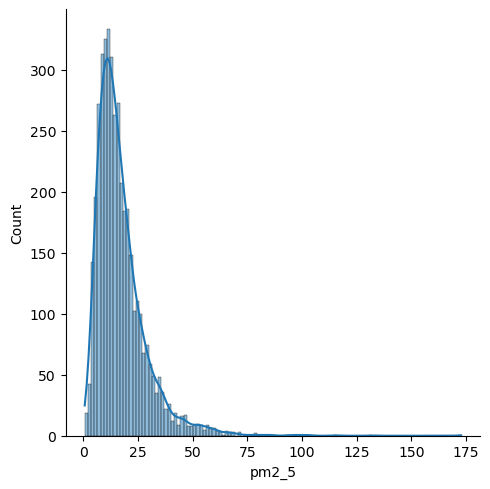

In [9]:

plt.figure(figsize = (12, 6))
sns.displot(train_data[target], kde = True)
plt.show()

We can understand a little bit more the overall air quality by creating categories: 

- Good: pm2_5 < 12.5
- Fair: pm2_5 [12.5–25]
- Poor: pm2_5 	[25–50]
- Very poor: pm2_5 [50–150]
- Extremely poor: pm2_5 More than 150


In [10]:
train_data.groupby('city')[target].mean()

city
Bafoussam     21.769081
Bamenda       20.146944
Bertoua       17.205552
Buea          13.955294
Douala        16.375233
Ebolowa       10.882733
Garoua        21.008722
Maroua        18.974740
Ngaoundéré    14.738632
Yaoundé       16.215085
Name: pm2_5, dtype: float64

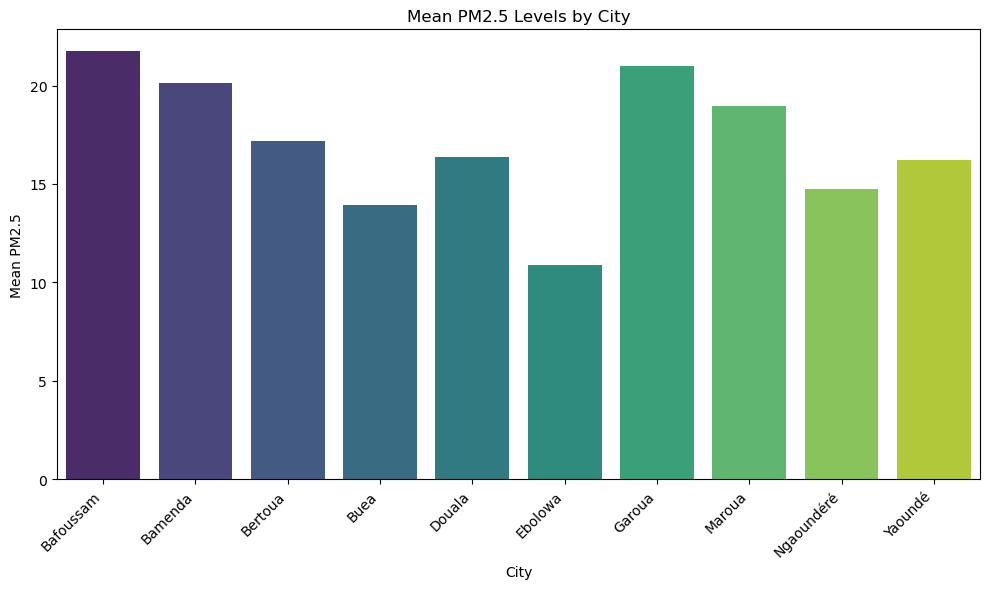

In [11]:
mean_pm2_5_by_city = train_data.groupby('city')[target].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='city', y=target, data=mean_pm2_5_by_city, palette='viridis')
plt.title('Mean PM2.5 Levels by City')
plt.xlabel('City')
plt.ylabel('Mean PM2.5')
plt.xticks(rotation=45, ha='right')  # Rotate city names for better readability
plt.tight_layout()

# Show the plot
plt.show()

On average the air quality amongs the different cities in Cameroon is fair.

Features like sunrise, sunset, snowfall_sum are non existent in a country like Cameroon, that's why all the values for these features are 0. They are constant so we can delete them

In [12]:
train_data.drop(['sunset', 'snowfall_sum', 'sunrise'], axis = 1, inplace = True)
test_data.drop(['sunset', 'snowfall_sum', 'sunrise'], axis = 1, inplace = True)

# Feature Distribution

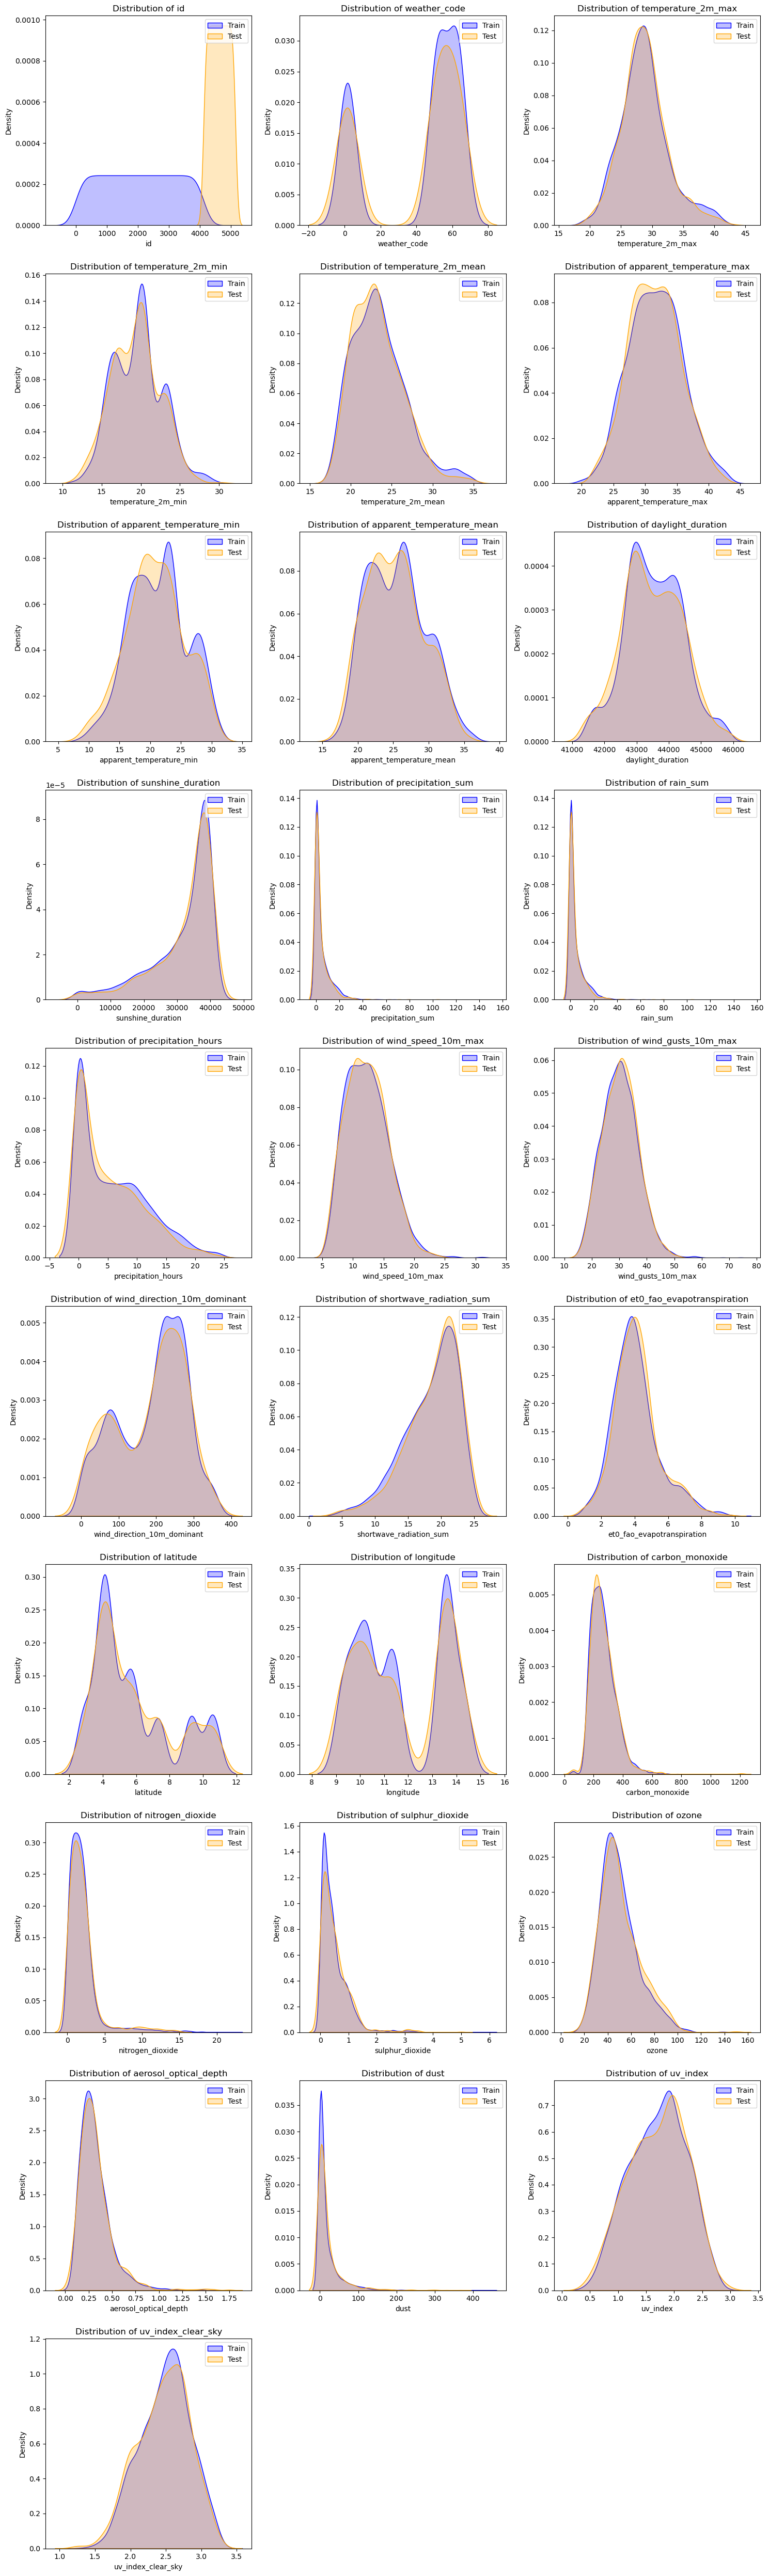

In [13]:
# Create a figure with subplots for each feature
features = list(test_data.select_dtypes(['Int64', 'float64'])) # List of all features in your dataset
n_features = len(features)  # Number of features to plot

# Number of columns per row (3 features per row)
n_cols = 3
# Number of rows, calculated by dividing the total features by the number of columns
n_rows = math.ceil(n_features / n_cols)

# Set up the figure with subplots (n_rows x n_cols grid)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Adjust the figure size

# Flatten the axes array for easy iteration, if needed
axes = axes.flatten()

# Iterate through each feature and plot its distribution for train and test sets
for i, feature in enumerate(features):
    ax = axes[i]
    
    # Plot the distribution of the feature in the train set
    sns.kdeplot(train_data[feature], ax=ax, label='Train', color='blue', fill=True)
    
    # Plot the distribution of the feature in the test set
    sns.kdeplot(test_data[feature], ax=ax, label='Test', color='orange', fill=True)
    
    # Set plot labels and title
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend()

# Remove any empty subplots if the number of features is not a multiple of n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()

The distribution of data in the train and test set appear to be relatively the same. We observe that some features are right and left skewed distributed. We can use log transformation to deal with that.

In [14]:
train_data.drop('id', axis = 1, inplace = True)
id = test_data['id']
test_data.drop('id', axis = 1, inplace = True)

## Numerical and Categorical feature

In [15]:
categorical_features = [col for col in list(test_data.select_dtypes('object'))]
numeric_features = [col for col in list(test_data.select_dtypes(['Int64', 'float64']))]

print("------------ Categorical columns---------------\n")
print(categorical_features)
print("\n------------ Numeric columns-------------------\n")
print(numeric_features)

------------ Categorical columns---------------

['city']

------------ Numeric columns-------------------

['weather_code', 'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'apparent_temperature_max', 'apparent_temperature_min', 'apparent_temperature_mean', 'daylight_duration', 'sunshine_duration', 'precipitation_sum', 'rain_sum', 'precipitation_hours', 'wind_speed_10m_max', 'wind_gusts_10m_max', 'wind_direction_10m_dominant', 'shortwave_radiation_sum', 'et0_fao_evapotranspiration', 'latitude', 'longitude', 'carbon_monoxide', 'nitrogen_dioxide', 'sulphur_dioxide', 'ozone', 'aerosol_optical_depth', 'dust', 'uv_index', 'uv_index_clear_sky']


In [16]:
X = train_data.drop(target, axis = 1)
y = train_data[target]

## Combining all the transformations with a ColumnTransformer

In [17]:
#Custom function for log transformation 
def log_transform(X):
    return np.log1p(X)

#Create a LabelEncoder for each categorical feature
label_encoders = {col: LabelEncoder() for col in categorical_features}

def label_encode(X):
    X = X.copy()
    for feature in categorical_features:
        X[feature] = label_encoders[feature].fit_transform(X[feature])
    return X

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 
         Pipeline(steps = [('log', FunctionTransformer(log_transform)), ('scaler', StandardScaler())]), 
         numeric_features),
        ('cat', FunctionTransformer(label_encode), categorical_features)
    ], 
    remainder = 'passthrough'
    )

def to_dataframe(X, feature_names):
    return pd.DataFrame(X, columns = feature_names)

#Fit and transform the training data
X_transformed = preprocessor.fit_transform(X)
X = to_dataframe(X_transformed, X.columns)

#Transform the test data
test_data_transformed = preprocessor.transform(test_data)
test_data = to_dataframe(test_data_transformed, test_data.columns)



In [18]:
X.shape, test_data.shape, y.shape

((4120, 28), (1030, 28), (4120,))

## Training Pipeline

### Train test split

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 42)

## Hyperparameter tuning with Optuna

In [20]:
# import optuna

In [21]:
# def objective(trial): 
#         """Define the objective function"""
#         params = {
#         'max_depth': trial.suggest_int('max_depth', 1, 20),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
#         'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
#         'eval_metric': 'rmse',
#         'use_label_encoder': False, 
#         'tree_method' : 'hist', 
#         'verbosity': 0, 
#         'device': 'gpu'
#         #'early_stopping_rounds': 20
#     }

#     # Fit the model
#         optuna_model = XGBR(**params)
#         optuna_model.fit(X_train, y_train)

#     # Make predictions
#         y_pred = optuna_model.predict(X_val)

#     # Evaluate predictions
#         rmse = np.sqrt(mean_squared_error(y_val, y_pred))
#         return rmse


# #Create the optuna study

# study = optuna.create_study(direction = 'minimize')
# study.optimize(objective, n_trials = 100)

# #Print the best parameters
# print("Number of finished trials: {}".format(len(study.trials)))
# print('Best trial: ')

# trial = study.best_trial

# print(' Value: {}'.format(trial.value))
# print(' Params: ')

# for key, value in trial.params.items(): 
#     print('   {}: {}'.format(key, value))

In [22]:
regressors = [  ("XGBR2", XGBR(**default_config["models"]["xgbr"])), 
              ("XGBR1", XGBR(**default_config["models"]["xgbr1"])), 
              ("XGBR", XGBR(**default_config["models"]["xgbr"])), 
              ]

In [23]:
X.shape, test_data.shape

((4120, 28), (1030, 28))

In [24]:
# X.drop(['latitude', 'longitude'], axis = 1, inplace = True)
# test_data.drop(['latitude', 'longitude'], axis = 1, inplace = True)

## Cross Validation

In [29]:
# Define the custom RMSLE function
def custom_rmse(y_val, y_pred):
    return np.sqrt(mean_squared_error(y_val, y_pred))

# Create a custom scorer for RMSLE
custom_rmse_scorer = make_scorer(custom_rmse, greater_is_better=False)

def train_and_log_model(model_name, model, X, y):
    with mlflow.start_run() as run:
        pipeline = Pipeline(steps = [(model_name, model)])
        cv_results = cross_validate(pipeline, X, y, cv = KFold(n_splits = default_config["cv"]["n_splits"], shuffle = default_config["cv"]["shuffle"], random_state = default_config["cv"]["random_state"]), scoring = custom_rmse_scorer, n_jobs = default_config["n_jobs"], return_train_score = True)

        pipeline.fit(X, y)

         #Extract the XGBoost model from the pipeline
        xgb_model = pipeline.named_steps[model_name]

         # Log only the most important parameters
        important_params = {
            "max_depth": xgb_model.max_depth,
            "learning_rate": xgb_model.learning_rate,
            "n_estimators": xgb_model.n_estimators,
            "colsample_bytree": xgb_model.colsample_bytree,
            "subsample": xgb_model.subsample
        }

        mlflow.log_params({"model name": model_name})
        mlflow.log_params(important_params)
        mlflow.log_metrics({"Mean Train RMSE Score": np.mean(cv_results['train_score'])})
        mlflow.log_metrics({"Mean Test RMSE Score": np.mean(cv_results['test_score'])})

       #Add tags
        mlflow.set_tags(default_config["mlflow"]["tags"])

        mlflow.xgboost.log_model(
                registered_model_name = model_name,
                artifact_path = model_name,
                xgb_model = xgb_model,
                input_example = X)
        
        return {
            "Model Name": model_name,
            "Mean Train RMSE Score": np.mean(cv_results['train_score']),
            "Mean Test RMSE Score": np.mean(cv_results['test_score']), 
            "Run ID": run.info.run_id
        }
    

try: 
    results = [train_and_log_model(model_name, model, X, y) for model_name, model in regressors]
    results_df = pd.DataFrame(results)
except Exception as e: 
    print(f"An error occured: {str(e)}")

2024/10/11 15:13:15 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under s3://air-quality-prediction-bucket/1/06c745047aa74cc3abdf15de9d58704d/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
Successfully registered model 'XGBR2'.
2024/10/11 15:13:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBR2, version 1
Created version '1' of model 'XGBR2'.
2024/10/11 15:15:30 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under s3://air-quality-prediction-bucket/1/12ac13ee1c5d4fb4bec2817ea9da6492/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
Successfully registered model 'XGBR1'.
2024/10/11

## Get the Best Model and the Best run

In [31]:
best_model = results_df.loc[results_df['Mean Test RMSE Score'].idxmax()]
best_run_id = best_model['Run ID']
best_model_name = best_model['Model Name']

print(f"The best model is {best_model_name} with a Mean Test RMSE Score of {best_model['Mean Test RMSE Score']:.4f}")
print(f"The best run ID is {best_run_id}")


The best model is XGBR2 with a Mean Test RMSE Score of -3.3448
The best run ID is 06c745047aa74cc3abdf15de9d58704d


## Feature Importance

2024/10/11 15:41:46 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


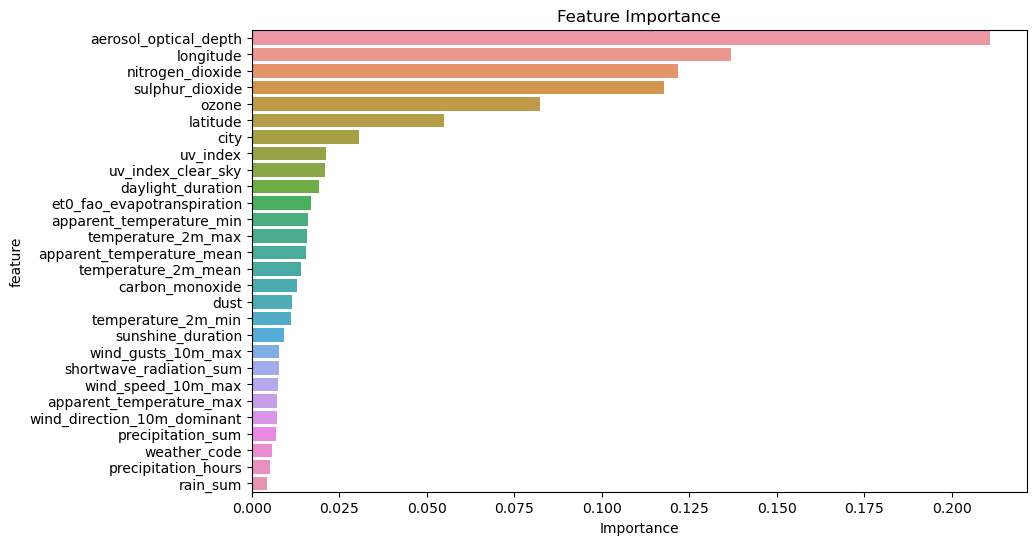

In [33]:

logged_model = f'runs:/{best_run_id}/{best_model_name}'
# Load model as a PyFuncModel.
loaded_model = mlflow.xgboost.load_model(logged_model)

# Let's look feature importance

feature_importances = loaded_model.feature_importances_

# Get the feature names
feature_names = X.columns

#Create a DataFrame to better display the feature importance
feature_importance_df = pd.DataFrame({"feature": feature_names, "importance": feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by = "importance", ascending = False)

# Plot the feature importance
plt.figure(figsize = (10, 6))
sns.barplot(x = "importance", y = "feature", data = feature_importance_df)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.savefig("feature_importance_plot.png")
plt.show()

#Save the feature importance plot in Mlflow
mlflow.log_artifact("feature_importance_plot.png", artifact_path = "feature_importance.png", run_id=best_run_id)


## Make Predictions

In [34]:
preds = loaded_model.predict(test_data)
preds_df = pd.DataFrame({"id": id, "pm2_5": preds})

preds_df.head()

,id,pm2_5
0,4120,11.251650
1,4121,12.845245
2,4122,12.716891
3,4123,14.494819
4,4124,13.454638


In [8]:
import pandas as pd
submission_df = pd.read_csv('../data/train_test_data/raw_data/submission.csv')
submission_df
submission_df.drop(['id', 'Usage'], axis = 1, inplace = True)
submission_df.head()
submission_df.to_csv('../data/train_test_data/preprocessed_data/test_target.csv', index = False)
